In [1]:
# Load pickled data
import os
import glob

# Locate vehicle images
directory = '../vehicles/'
image_types = os.listdir(directory)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(directory+imtype+'/*'))

print('No.of vehicle images:',len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

# Locate non-vehicle images
directory = '../non-vehicles/'
image_types = os.listdir(directory)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(directory+imtype+'/*'))
    
print('No.of non vehicle images:',len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

No.of vehicle images: 8792
No.of non vehicle images: 8968


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Convert image to new color space (if specified)
    color1 = cv2.resize(img[:,:,0], size).ravel()        
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()

    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)                       
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)           
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
       
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []            
            for channel in range(feature_image.shape[2]):                
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))                 
        else:            
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = np.ravel(hog_features)
       
    #8) Append features to list
        img_features.append(hog_features)
        
    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    wname = 'Rx_img.jpg'
    cv2.imwrite(wname, img)   
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        wname = 'window_img.jpg'
        cv2.imwrite(wname, cv2.resize(test_img,None,fx=1, fy=1, interpolation = cv2.INTER_LINEAR))
        wname = 'test_img.jpg'
        cv2.imwrite(wname, test_img)
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #8) Return windows for positive detections
    return on_windows
    
def visualize_data(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        

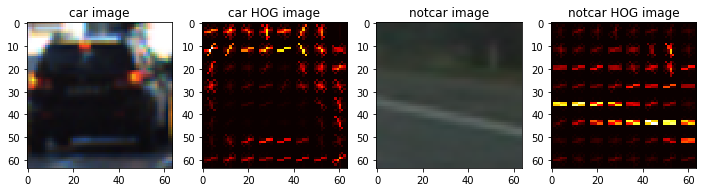

In [4]:
%matplotlib inline

# Choose random car/ not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True) 
    
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize_data(fig, 1, 4, images, titles)

## Classifier


In [5]:
# Define feature params
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t, 2), 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

79.12 Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
36.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [7]:
searchpath = './test_images/test*'
test_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)    
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    #Sliding windows
    windows = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop, 
                          xy_window=(64,64), xy_overlap=(overlap,overlap))
  
    # Hot windows = windows where the classifier thinks it found a car in the image
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

#fig = plt.figure(figsize=(12,18), dpi=300)
#visualize_data(fig, 5, 2, images, titles)


0.0 1.0
1.8511056900024414 seconds to process one image searching 273 windows
0.0 1.0
1.6210927963256836 seconds to process one image searching 273 windows
0.0 1.0
1.5870907306671143 seconds to process one image searching 273 windows
0.0 1.0
1.6170926094055176 seconds to process one image searching 273 windows
0.0 1.0
1.561089277267456 seconds to process one image searching 273 windows
0.0 1.0
1.6140923500061035 seconds to process one image searching 273 windows


0.23201322555541992 seconds to run, total windows= 156
0.1740100383758545 seconds to run, total windows= 156
0.18001031875610352 seconds to run, total windows= 156
0.17000985145568848 seconds to run, total windows= 156
0.17901039123535156 seconds to run, total windows= 156
0.1740097999572754 seconds to run, total windows= 156


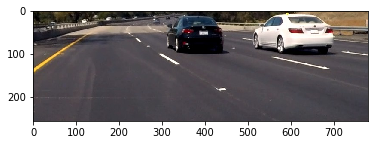

In [8]:
out_images = []
out_maps  = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
xstart = 500
scale = 1.6

# Iterate over test images
for img_src in test_images:
    img_boxes = []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    plt.imshow(img_tosearch)
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')               
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left+xstart:xbox_left+xstart+win_draw] +=1
                
    print(time.time()-t, 'seconds to run, total windows=', count)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
#fig = plt.figure(figsize=(12,24))
#visualize_data(fig, 8, 2, out_images, out_titles)
    
    
    

In [9]:
from scipy.ndimage.measurements import label
  
class Vehicle():
    def __init__(self):        
        self.xmin = []
        self.xmax = []
        self.ymin = []
        self.ymax = []    
        
class heat_it_up():
    def __init__(self):
        self.heatmap = np.zeros_like(img[:,:,0]).astype(np.float)  
        self.detection_count = 0
        
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def remove_heat(heatmap, bbox_list, amount):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Remove -= amount for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= amount
    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


carslist = []
def draw_labeled_bboxes_1(img, labels):
    # Iterate through all detected cars
    
    for car_number in range(1, labels[1]+1):
        carslist.append(Vehicle())
        #print("carslist=",carslist)
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        xmin = np.min(nonzerox)
        ymin = np.min(nonzeroy)
        xmax = np.max(nonzerox)
        ymax = np.max(nonzeroy)
        
        vehicle = carslist[car_number-1]
        vehicle.xmin.append(xmin)
        vehicle.ymin.append(ymin)
        vehicle.xmax.append(xmax)
        vehicle.ymax.append(ymax)
        
        frames_to_avg = 10
        if len(vehicle.xmin) > frames_to_avg:            
            xmin_avg = np.int(np.mean(vehicle.xmin))
            ymin_avg = np.int(np.mean(vehicle.ymin))
            xmax_avg = np.int(np.mean(vehicle.xmax))
            ymax_avg = np.int(np.mean(vehicle.ymax))
            
            # To keep len of the array fixed to 5
            vehicle.xmin.pop(0)
            vehicle.ymin.pop(0)
            vehicle.xmax.pop(0)
            vehicle.ymax.pop(0)  
            carslist.pop(frames_to_avg)
            
            bbox = ((xmin_avg, ymin_avg), (xmax_avg, ymax_avg))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [10]:
# Wrap all what was done above into single function that can extract features 
# using hog sub-sampling and make predictions

out_images = []
out_maps  = []
titles = []
ystart = 400
ystop = 656
xstart = 500
scale = 1.6

def find_cars(img, scale):    
    
    # For scaling JPEG image frames
    img = img.astype(np.float32)/255   
    #print(np.min(img), np.max(img))
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list= []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                
                box_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                
    return box_list

In [11]:
# Check if the averaging works over frames

out_images = []
out_maps  = []
titles = []
ystart = 400
ystop = 656
xstart = 500
scale = 1.6

searchpath = './frames/img12*'
#searchpath = './frames/frame*'
#searchpath = './test_images/test5.jpg'
#searchpath = './frames/img1221.png'
frames = glob.glob(searchpath)

# Init heat_it_up class
heat_update = heat_it_up()

#Iterate over test images
for img_src in frames:      
    img = mpimg.imread(img_src) 
    
    draw_img = np.copy(img)    
        
    box_list = find_cars(img, scale)  
    print("no of boxes=",len(box_list))   
    
    if (len(box_list)) != 0:
        heatmap = add_heat(heat_update.heatmap,box_list)
        heat_update.heatmap = heatmap
        heat_update.detection_count += 1
    
    heatmap_max = np.max(heat_update.heatmap)
    print("det count=", heat_update.detection_count)
    print("max",heatmap_max)
    
    heat_limit = 9.0
    if (heatmap_max > heat_limit):
        print("Removing heat")
        amount = heatmap_max - heat_limit
        heatmap = remove_heat(heat_update.heatmap,box_list, amount)
        
        heat_update.heatmap = heatmap
        print("after removing heat",np.max(heat_update.heatmap))
           
    if heat_update.detection_count > 2:
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat_update.heatmap,0)

        labels = label(heat)    
        print("Labels =",labels[1])        

        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        print("RESET")
        
        heat_update.detection_count = 0
        #heat_update = heat_it_up()
        
        print("*****************")
        
        out_images.append(draw_img)
        out_images.append(heat)
        titles.append(img_src[-12:])
        titles.append(img_src[-12:])

fig = plt.figure(figsize=(12,24))
visualize_data(fig, 11, 2, out_images, titles)

no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0
no of boxes= 0
det count= 0
max 0.0


In [14]:
# Init heat_it_up class
global heat_update 
heat_update = heat_it_up()

def process_image(img):
    draw_img = np.copy(img)  
    global heat_update
    
    box_list = find_cars(img, scale)
    
    if (len(box_list)) != 0:
        heatmap = add_heat(heat_update.heatmap,box_list)
        heat_update.heatmap = heatmap
        heat_update.detection_count += 1
    
    heatmap_max = np.max(heat_update.heatmap)
    #print(heatmap_max)
           
    if heat_update.detection_count > 2:
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat_update.heatmap,4)

        labels = label(heat)    
        
        # If the program thinks atleast 1 car is found
        #if labels[1] != 0:
        draw_img = draw_labeled_bboxes_1(np.copy(img), labels)
        
        heat_update = heat_it_up()
        heat_update.detection_count = 0
        
    return draw_img

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test6.mp4'
#clip = VideoFileClip("test_video.mp4")
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test6.mp4
[MoviePy] Writing video test6.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:53<00:00,  4.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test6.mp4 

